# Project description
The goal of this project was to help optimize the process of gold purification from gold ore. We were provided with past data on various purification process parameters (e.g. input concentrations, floatbank parameters, etc.) as well as the target features (gold recovery rate). Our task was to build a model that will predict gold recovery rate given a set of purification process parameters. This model will help fine tune purification parameters to achieve maximum recovery.

# Technical process 

 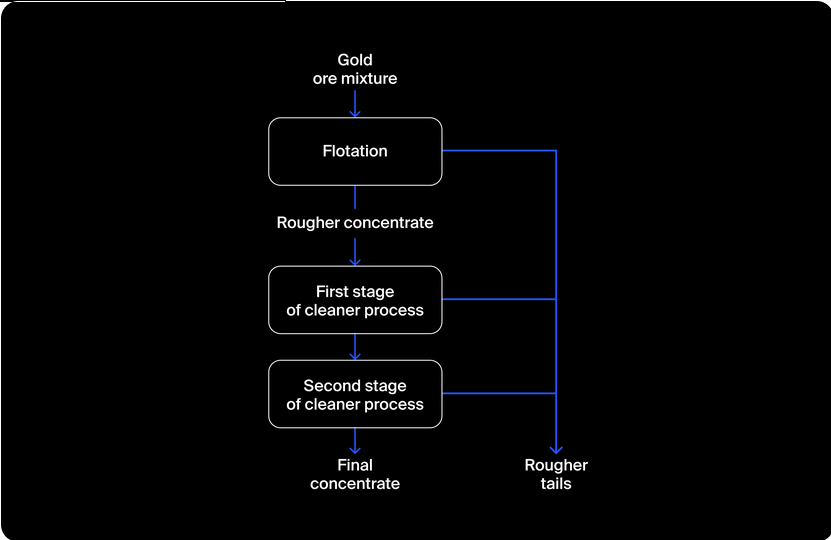

# data description

+ The data is stored in three files:
  + gold_recovery_train.csv — training dataset 
  + gold_recovery_test.csv — test dataset 
  + gold_recovery_full.csv — source dataset 
  
+ Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar.
+ Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.
+ The source dataset contains the training and test sets with all the features.
  We have the raw data that was only downloaded from the warehouse.
+ Our target variables are the recovery rate from the rougher, and the final recovery.

# Imports

In [135]:
from IPython.display import display

# general purpose libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.cm import get_cmap
import seaborn as sns
from num2words import num2words

# pre-processing
from sklearn.preprocessing import StandardScaler

# model selection
from sklearn.model_selection import train_test_split
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
# modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.tree import DecisionTreeRegressor

# model evaluation
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor


# supress warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting setup

In [136]:
# qualitative color map
qualitative_cm = 'tab20c'

# pyplot style
plt.style.use('ggplot')



# font
font_style = {
    'family' : 'monospace',
    'weight' : 'normal',
    'size'   : 12
}
plt.rc('font', **font_style)

# axes 
axes_style = {
    'titlesize': 15,
    'labelpad': 6.0,
    'labelsize': 13.0
}
plt.rc('axes', **axes_style)

# figure
figure_style = {
    'figsize': (10, 6)
}
plt.rc('figure', **figure_style)

# Load the data

In [137]:
recovery_train = pd.read_csv('./datasets/gold_recovery_train.csv')
recovery_test = pd.read_csv('./datasets/gold_recovery_test.csv')    
recovery_full = pd.read_csv('./datasets/gold_recovery_full.csv')


# Constants

In [138]:
DATASETS = [
    recovery_train,
    recovery_test,
    recovery_full
]

DATASETS_LABELS = [
    'Train',
    'Test',
    'Full'
]

TARGETS = [
    'rougher.output.recovery',
    'final.output.recovery'
]



# Initial overview

## Time frame

In [139]:
timestamps = pd.to_datetime(recovery_train['date'])
time_range = timestamps.max() - timestamps.min()

print(
    f"Data contains records over "
    f"{time_range.days} days (~2.5 years)"
)

Data contains records over 946 days (~2.5 years)


## Shape

In [140]:
for label, dataset in zip(DATASETS_LABELS, DATASETS):
    print(
        f"{label} set\n"
        f"-------------"
    )
    
    print(
        f"Observations: {dataset.shape[0]}\n"
        f"Features: {dataset.shape[1]}\n"
#         f"Data types:\n{dataset.dtypes}\n"
    )
    print()

Train set
-------------
Observations: 16860
Features: 87


Test set
-------------
Observations: 5856
Features: 53


Full set
-------------
Observations: 22716
Features: 87




## Info

In [141]:
recovery_train.info()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


## Targets
TODO:
+ plot:
    + title
    + labels
    + fix ticks for hour based dynamics

<!-- TODO:
+ plot
    + xticks for targets-by-date
    + figure legend
    + y lables
    + labels font size
    + titles -->

In [142]:
def get_random_days(data, days=1, seed=None):
    index = data.index.to_series()
    random_start_date = index.sample().dt.date.values[0]
    end_date = (random_start_date
                + pd.Timedelta(days, 'D'))
    
    random_days = data.loc[random_start_date : end_date]
    return random_days



In [143]:
# select targets and date feature
targets = recovery_full[['date'] + TARGETS]
targets['date'] = pd.to_datetime(targets['date'])
targets.set_index('date', inplace=True)

# display first few observations
targets.head()

,rougher.output.recovery,final.output.recovery
date,,
2016-01-15 00:00:00,87.107763,70.541216
2016-01-15 01:00:00,86.843261,69.266198
2016-01-15 02:00:00,86.842308,68.116445
2016-01-15 03:00:00,87.226430,68.347543
2016-01-15 04:00:00,86.688794,66.927016


* Hourly records

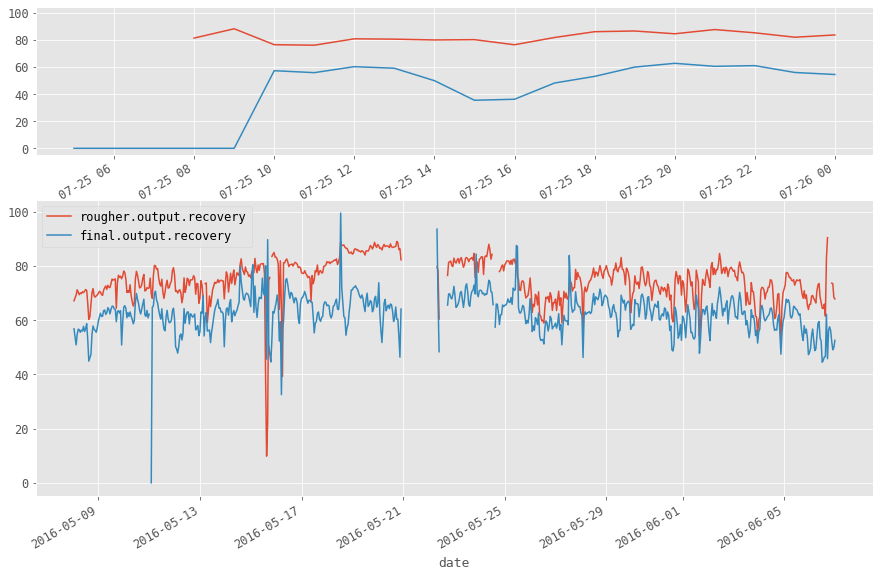

In [144]:
# group targets by date (daily mean)
date = targets.index.date
targets_by_date = targets.groupby(date).mean()

# randomly select a 24h interval to plot hourly values
targets_random_24hours = get_random_days(targets)

# randomly select a 1 month interval to plot daily mean 
targets_random_month = get_random_days(targets, days=30, seed=54321)

# initialize figure
fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    sharey=True,
    figsize=(15, 10),
    gridspec_kw={'height_ratios':[1,2]}
)
upper_ax = axes[0]
lower_ax = axes[1]

# plot targets by date and by hour
targets_random_24hours.plot(ax=upper_ax, legend=False)
targets_random_month.plot(ax=lower_ax);



array([[<AxesSubplot:title={'center':'rougher.output.recovery'}>,
        <AxesSubplot:title={'center':'final.output.recovery'}>]],
      dtype=object)

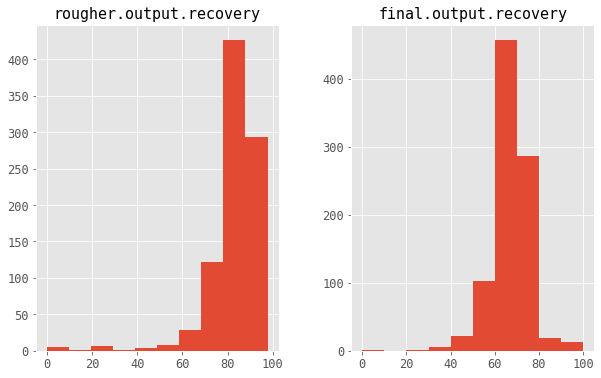

In [145]:
targets_by_date.hist()

In [146]:
# timestamps = targets.index
# timestamps.hour
targets_by_hour_of_day = (
    targets.groupby(targets.index.hour).mean()
)
range_hour_of_day = (targets_by_hour_of_day.max()
                     - targets_by_hour_of_day.min())
range_date = (targets_by_date.max()
              - targets_by_date.min())
ranges = (
    pd.concat([range_date, range_hour_of_day], axis=1)
)
ranges.columns = ['by date', 'by hour of day']

print(
    'range of target values\n'
    '----------------------\n'
)

ranges


range of target values
----------------------



,by date,by hour of day
rougher.output.recovery,97.669641,1.836840
final.output.recovery,100.000000,1.105316


## Conclusions

* Train set contains hourly records over a period of roughly 2.5 years.
* Our features contains information about:
    + Floatation systems, the air volume, fluid levels.
    + The feed particle size.
    + Concentration of the different added reagents.
    + Metal concentrates for output and tails.
* Both rougher and final recovery are almost constant with respect the hour of the day.
* Strong fluctuations in recovery rates are observed between dates.

# Pre-processing

## Convert `date` column to 'datetime'

In [147]:
recovery_train['date'] = pd.to_datetime(recovery_train['date'])
recovery_test['date'] = pd.to_datetime(recovery_test['date'])
recovery_full['date'] = pd.to_datetime(recovery_full['date'])

## Create a copy of the data sets before pre-processing

In [148]:
train_raw = recovery_train.copy()
test_raw = recovery_test.copy()
full_raw = recovery_full.copy()

In [149]:
print(
    train_raw.shape
)

(16860, 87)


## Check recovery calculation
This is done to make sure that recovery data is correct. The formula being used is how recovery is defined by the process managers.

### Calculate `rougher.output.recovery`

1) $Recovery\ =\ \frac{C*(F-T)}{F*(C-T)}*100\%$

    + C — share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
    + F — share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)
    + T — share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)

In [150]:
# calculate rougher.output.recovery from formula using provided features
F = recovery_train['rougher.input.feed_au'] # share of gold in the floatation feed
C = recovery_train['rougher.output.concentrate_au'] # share of gold in the concentrate right after floatation
T = recovery_train['rougher.output.tail_au'] # share of gold in the rougher tails (residue after floatation)

calculated_rougher_output_recovery = (C * (F-T)) / (F * (C-T)) * 100


### MAE for train set recovery and calculated recovery

$MAE\ =\ \frac{1}{N}\ \Sigma_{i=0}^{N-1}\ |y_i - \hat{y}_i|$

In [151]:
# rougher.output.recovery from train data set
train_rougher_output_recovery = recovery_train['rougher.output.recovery'] 

# merge train and calculated recovery
concatenated = pd.concat(
    [
        train_rougher_output_recovery,
        calculated_rougher_output_recovery
    ],
    keys=['train', 'calculated'],
    axis=1
)

# absolute difference 
concatenated['abs_diff'] = concatenated.apply(
    lambda row: np.absolute(row['train'] - row['calculated']),
    axis=1
)

# MAE
mae = concatenated['abs_diff'].sum() / len(concatenated)

print()
print(
    f"MAE train Vs. calculated: {mae:.2e}"
)
print()


MAE train Vs. calculated: 7.88e-15



### Conclusion

* Provided recovery data is correct, as MAE is practically zero.

## Features missing from test set


### Absent features

In [152]:
missing_features = (
    set(recovery_train.columns)
    - set(recovery_test.columns)
)

In [153]:
print()
print(
    f"Number of features missing from test set: "
    f"{len(missing_features)}\n"
)
print()
print(
    "Missing features\n"
    "----------------"
)
for feature in missing_features:
    print(feature) 


Number of features missing from test set: 34


Missing features
----------------
final.output.tail_sol
secondary_cleaner.output.tail_pb
final.output.concentrate_ag
rougher.output.tail_sol
primary_cleaner.output.concentrate_pb
final.output.concentrate_au
final.output.tail_pb
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.output.recovery
secondary_cleaner.output.tail_sol
primary_cleaner.output.tail_pb
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.output.concentrate_ag
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_sol
rougher.calculation.au_pb_ratio
rougher.calculation.sulfate_to_au_concentrate
primary_cleaner.output.concentrate_au
final.output.concentrate_sol
rougher.output.concentrate_pb
primary_cleaner.output.tail_au
rougher.output.concentrate_sol
secondary_cleaner.output.tail_au
final.output.tail_ag
final.output.tail_au
final.output.recovery
final.output.concentrate_pb
rougher.output.tail_au
secondary_cleaner.output.tail_ag
rougher.

### Conclusions

* Features missing from the test set are:

    + **Features that would not be available as mopel inputs when prediction is required in real time**, since they are calculated\measured after online measurments have already being obtained. 
    + **Features that largly correspond with our target variables**, making them unfit for use in model training (introduce data leakage).

<!-- + For the above reasons, these features are excluded from the train set. -->


## List of features, excluding  redundant features (missing features)

In [154]:
FEATURES = list(set(recovery_full.columns) - missing_features - set(['date']))
set(FEATURES)

{'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_au',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rough

## Examine feature dynamics
TODO: add legend to plot.

<!-- TODO:
+ plot a random sample of observations. -->

In [155]:
scaler = StandardScaler()
scaler.fit(recovery_train[FEATURES])

# features' data slice
train_features_scaled = pd.DataFrame(scaler.transform(recovery_train[FEATURES]))

# group selected features by date
features_by_date = (
    train_features_scaled
    .pivot_table(index=[recovery_train['date'].dt.date])
)

# group targets by hour
features_by_hour = (
    train_features_scaled
    .pivot_table(index=[recovery_train['date'].dt.hour]) # group by hour of day
    .rename_axis('hour') # rename index axis
    .rename(index=lambda i: i+1) # rename index values from zero based to 24h scale
)


In [156]:
recovery_train['date']

0       2016-01-15 00:00:00
1       2016-01-15 01:00:00
2       2016-01-15 02:00:00
3       2016-01-15 03:00:00
4       2016-01-15 04:00:00
                ...        
16855   2018-08-18 06:59:59
16856   2018-08-18 07:59:59
16857   2018-08-18 08:59:59
16858   2018-08-18 09:59:59
16859   2018-08-18 10:59:59
Name: date, Length: 16860, dtype: datetime64[ns]

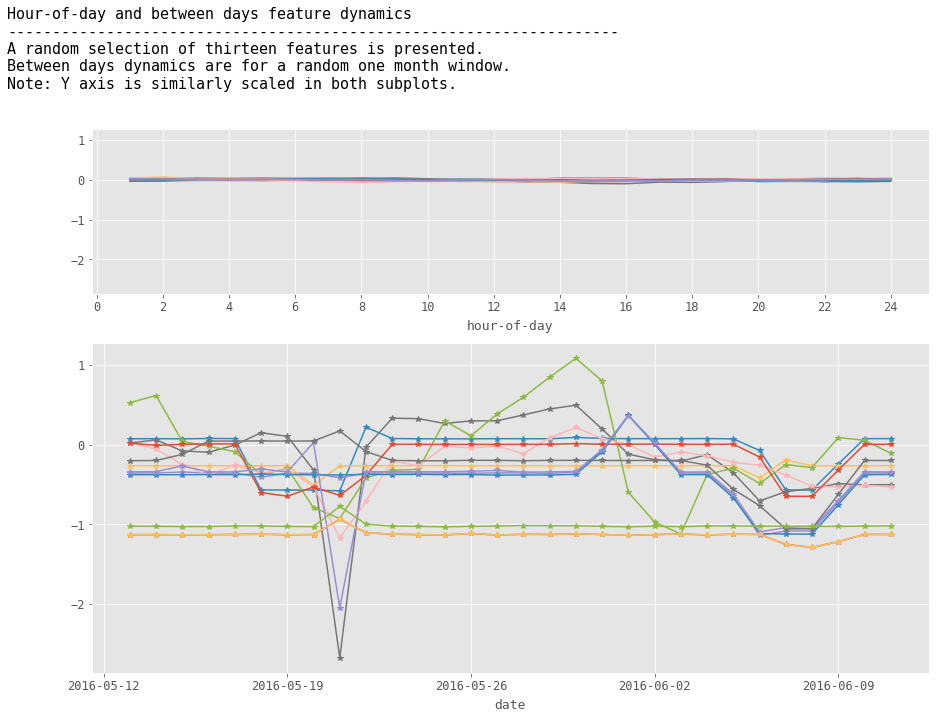

In [157]:
print()

# random selection of features
fraction_features_to_select = 0.25
n_total_features = len(FEATURES)
n_selected_features = int(
    n_total_features  
    * fraction_features_to_select
)
random_features = np.random.randint(
    0, n_total_features, size=n_selected_features
)

# number of dates to show for between-days-dynamics
date_window = 30

# random number between 0 and length of features_by_date to start a 1 month window from
start_date = np.random.randint(
    0, features_by_date.shape[0]
)
# initialize figure
fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    sharey=True,
    figsize=(15, 10),
    gridspec_kw={'height_ratios':[1,2]}
)
upper_ax = axes[0]
lower_ax = axes[1]




# plot features by date and by hour
features_by_hour.plot(ax=upper_ax, legend=False)
random_selection = features_by_date.iloc[
    start_date: start_date + date_window,
    np.r_[random_features]
]
random_selection.plot(ax=lower_ax, legend=False, marker='*')

# x ticks
upper_ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
lower_ax.xaxis.set_major_locator(ticker.MultipleLocator(7))

# x labels
upper_ax.set_xlabel("hour-of-day", size=13)
lower_ax.set_xlabel('date', size=13);


# figure title
title = (
    f"Hour-of-day and between days feature dynamics\n"
    f"--------------------------------------------------------------------\n"
    f"A random selection of {num2words(n_selected_features)} features is presented.\n"
    f"Between days dynamics are for a random {num2words(date_window / 30)} month window.\n"
    "Note: Y axis is similarly scaled in both subplots."
)
fig.suptitle(
    title,
    size=15,
    ma='left',
    x=0.33,
    y=1.05

    
);

# fig.legend()

### Conclusions

* Features values change minimaly within each day, while often fluctuating significantly between dates.


## Missing values

TODO: 
+ list Nan values as percentages
+ print out how many NaN values exist before fill.
+ how many NaN values exist in target and what portion of the data they represent

In [158]:
percent_missing_values = recovery_train.isnull().mean() * 100
print(
    "Percent missing values for features in train set\n"
    "----------------------------------------\n"
    f"{percent_missing_values.sort_values(ascending=False).head(20)}"
)

Percent missing values for features in train set
----------------------------------------
rougher.output.recovery                     15.260973
rougher.output.tail_ag                      13.345196
rougher.output.tail_sol                     13.339265
rougher.output.tail_au                      13.339265
secondary_cleaner.output.tail_sol           11.779359
rougher.input.floatbank11_xanthate          11.293001
final.output.recovery                        9.021352
primary_cleaner.input.sulfate                7.752076
primary_cleaner.input.depressant             7.485172
rougher.calculation.au_pb_ratio              7.366548
rougher.input.floatbank10_sulfate            6.192171
primary_cleaner.input.xanthate               5.842230
primary_cleaner.output.concentrate_sol       3.772242
rougher.input.floatbank11_sulfate            3.695136
rougher.state.floatbank10_e_air              3.576512
rougher.input.feed_rate                      3.042705
rougher.input.feed_size                      2

* Both target variables and several features have siginificant share of missing values.

### Fill missing values for features using forward fill
Given the low intra daily varaibilty observed earlier, we will fill missing values with the last valid value in the relevant column (feature).

In [159]:
# fill train set features
recovery_train.loc[:, FEATURES] = (
    recovery_train.loc[:, FEATURES].fillna(method='ffill')
)

# fill test set features
recovery_test.loc[:, FEATURES] = (
    recovery_test.loc[:, FEATURES].fillna(method='ffill')
)

# fill full set features
recovery_full.loc[:, FEATURES] = (
    recovery_full.loc[:, FEATURES].fillna(method='ffill')
)


### Remove observations where either targets are unavailable


#### Train set

In [160]:

# boolean mask for where either of the targets is NaN
target_is_nan = (
    recovery_train['rougher.output.recovery'].isnull() 
    | recovery_train['final.output.recovery'].isnull()
)

# count observations before removal
before = recovery_train.shape[0]

# select observations were neither targets is NaN
recovery_train = recovery_train.loc[~target_is_nan]

# observations after removal
after = recovery_train.shape[0]

# observations removed
n_removed = before - after

In [161]:
print(
    f"Observations removed: "
    f"{n_removed} ({n_removed / before:.2%})"
)

Observations removed: 2711 (16.08%)


#### Test set

In [162]:
# full data set boolean mask for where either of the targets is NaN
full_target_is_nan = (
    recovery_full['rougher.output.recovery'].isnull() 
    | recovery_full['final.output.recovery'].isnull()
)

# timestamp for the above observations
full_nan_timestamp = recovery_full[full_target_is_nan]['date']

# select observations in test set 
    # where targets for corresponding observations in full set are not NaN
before = recovery_test.shape[0]
recovery_test = (
    recovery_test[
        ~recovery_test['date'].isin(full_nan_timestamp) # inverse mask of observations where targets are NaN
    ]
)
after = recovery_test.shape[0]
n_removed = before - after

In [163]:
print(
    f"Observations removed: "
    f"{n_removed} ({n_removed / before:.2%})"
)

Observations removed: 566 (9.67%)


#### Full set

In [164]:

# boolean mask for where either of the targets is NaN
target_is_nan = (
    recovery_full['rougher.output.recovery'].isnull() 
    | recovery_full['final.output.recovery'].isnull()
)


before = recovery_full.shape[0]
recovery_full = recovery_full.loc[~target_is_nan]
after = recovery_full.shape[0]
n_removed = before - after

In [165]:
print(
    f"Observations removed: "
    f"{n_removed} ({n_removed / before:.2%})"
)

Observations removed: 3277 (14.43%)


### Final test for NaN values

In [166]:
print(
    f"Train set: {recovery_train[FEATURES + TARGETS].isnull().sum().sum()}\n"
    f"Test set: {recovery_test[FEATURES].isnull().sum().sum()}\n"
    f"Full set: {recovery_full[FEATURES + TARGETS].isnull().sum().sum()}\n"
    
#     f"NaN values in test set: {recovery_test.isnull().sum().sum()}\n\n"
#     f"train set NaNs:\n\n{recovery_train.isnull().sum()}"
)

Train set: 0
Test set: 0
Full set: 0



<!-- ### Examine frequency of Nan values -->

## Check for duplicates

In [167]:
datasets = [
    recovery_train,
    recovery_test,
    recovery_full
]
zipped = zip(
    DATASETS_LABELS,
    datasets
)

print(
    f"Duplicated observations\n"
    f"-----------------------"
)
for label, dataset in zipped:
    duplicates = dataset[dataset.duplicated()]
    print(
        f"{label} set: {duplicates.sum().sum()}"
    )

Duplicated observations
-----------------------
Train set: 0.0
Test set: 0.0
Full set: 0.0


In [168]:
print(
    f"Duplicated time stamps\n"
    f"----------------------\n"
    f"Full data set: {recovery_full['date'].duplicated().sum()}\n"
    f"Train set: {recovery_train['date'].duplicated().sum()}\n"
    f"Test set: {recovery_test['date'].duplicated().sum()}\n"
)

Duplicated time stamps
----------------------
Full data set: 0
Train set: 0
Test set: 0



## Add target variables to test set
These values were not provided with the test set.

In [169]:
recovery_test = recovery_test.merge(
    recovery_full[TARGETS + ['date']],
    on='date',
    how='left'
)

### Verify

In [170]:
# Full set observations with same time stamps as Test set observations
timestamps_in_test = (
    recovery_full['date']
    .isin(recovery_test['date'])
)
full_set_in_test = (
    recovery_full[timestamps_in_test]
)

# corresponding Full set targets 
full_set_targets_in_test = full_set_in_test[TARGETS].reset_index(drop=True)

# Test targets 
test_set_targets = recovery_test[TARGETS].reset_index(drop=True)

# test that all values are equal between Test set targets and Full set corresponding targets
all(full_set_targets_in_test == test_set_targets)

True

## Summary

* Recovery data was validated by calculating recovery from formula.
* Redundant features were noted and excluded from the set of features to be fed to the model. This will  allow a viable prediction model (i.e. model inputs will be available when prediction is to take place) and avoid data leakage.
* Feature dynamics were examined and time dependent variabilty noted. High inter daily variability as opposed to very low intra daily variability.
* Missing values in the feature section were filled with feature mean and observations were either targets were unavailble were removed. In this way all missing values were eliminated.
* No duplicated observations and timestamp duplicates were found.
* Target variables were added to test set.

# Analysis

+ Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.
+ Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.
+ Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. 


## Feed particle distribution

<!-- TODO:
* plot primary cleaner input feed size distribution
* plot
    + titles
    + labels
    + legend
    + remove grid
    + annotations with distrbution means -->

In [171]:
particle_size_train = train_raw['rougher.input.feed_size']
particle_size_test = test_raw['rougher.input.feed_size']


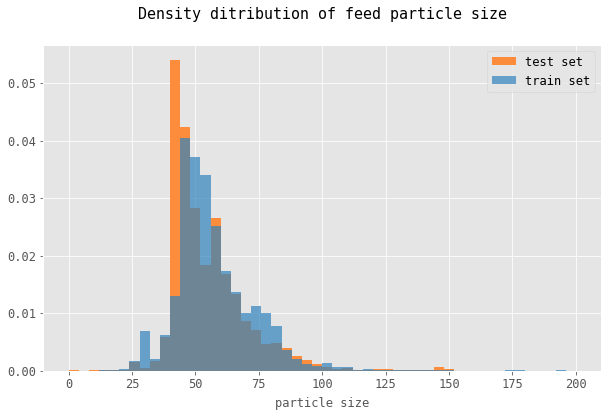

In [172]:
fig, ax = plt.subplots(
#     figsize=(8, 6)
)
nbins = 50

particle_size_test.hist(
    bins=nbins,
    density=True,
    range=(0, 200),
    color=get_cmap(qualitative_cm, 5).colors[1],
    grid=False,
    ax=ax,
)
particle_size_train.hist(
    bins=nbins,
    density=True,
    range=(0, 200),
    color=get_cmap(qualitative_cm, 5).colors[0],
    alpha=0.7,
#     grid=False,
    ax=ax,
)

# legend
labels = ['test set', 'train set']
handles = ax.containers
plt.legend(
    handles,
    labels,
    fontsize=12
)

# x label
plt.xlabel(
    'particle size',
    size=12
)

# title
plt.title(
    f"Density ditribution of feed particle size",
    size=15,
    y=1.06
);


* distributions of feed particle size are fairly similar in shape between train and test.

## Metal concentrations in purification stages

In [173]:
metals = ['au', 'ag', 'pb']
stages = [
    'rougher.output.concentrate',
    'primary_cleaner.output.concentrate',
    'final.output.concentrate'
]

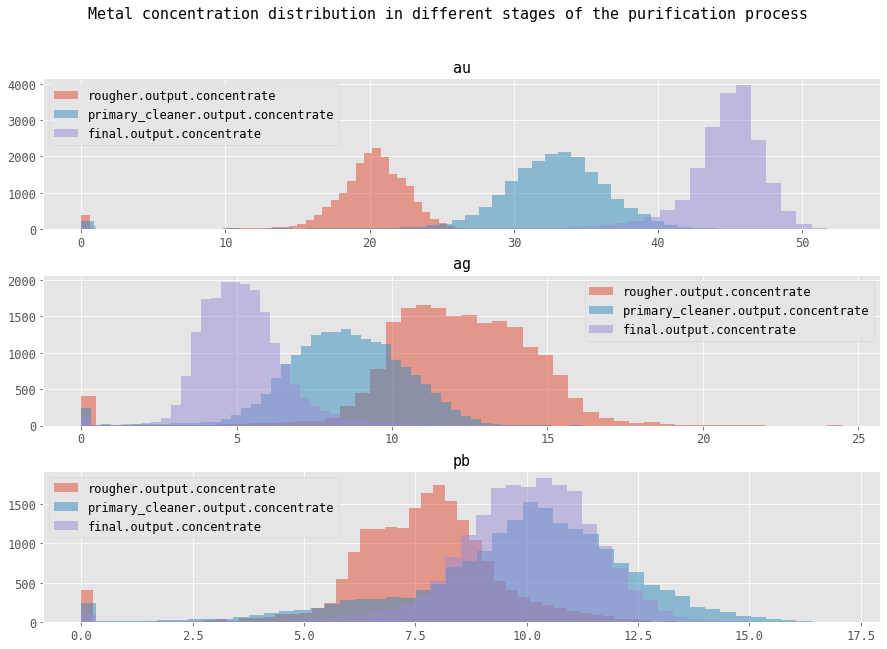

In [174]:
print()
figure, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(15, 10),
    gridspec_kw={'hspace': 0.3},
)

# title
figure.suptitle(
    "Metal concentration distribution in different stages of the purification process",
    size = 15,
    y=0.98
)

for i, metal in enumerate(metals):
    ax = axes[i]
    for stage in stages:
        feature = stage + '_' + metal
        recovery_full[feature].hist(
            bins=50,
            label=stage,
            alpha=0.5,
            ax=ax,
#             grid=False,
        )
    ax.set_title(metal)
    ax.legend()

* Distribution of Au concentration within each stage is roughly normaly distributed but with a long left tail.
* Some extreme left outliers exist in for all three metals in all three stages.
* Gold concetration is clearly increased with purification progress.

## Target distributions
<!-- TODO:
+ titles
+ labels -->

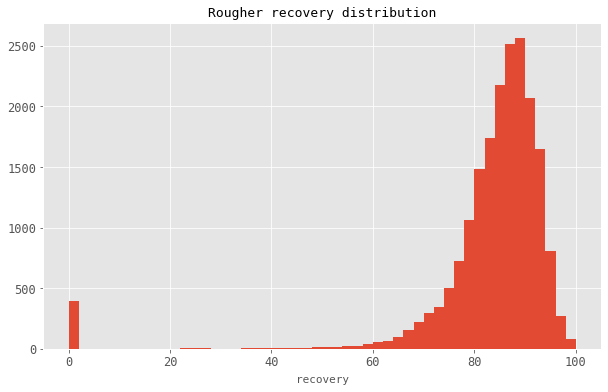

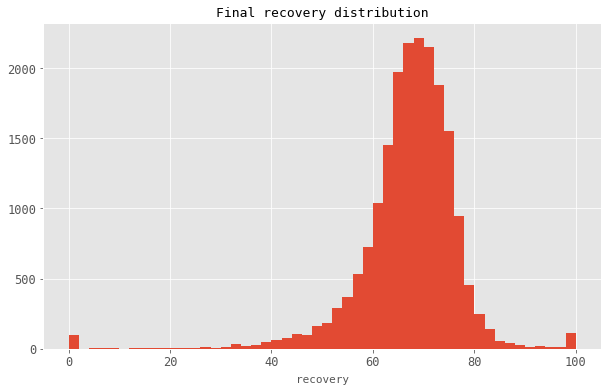

In [175]:

# rouhger recovery
recovery_full['rougher.output.recovery'].hist(bins=50)
plt.title(
    "Rougher recovery distribution",
    size=13
)
plt.xlabel(
    'recovery',
    size=11
)
plt.show()


# final recovery
recovery_full['final.output.recovery'].hist(bins=50)
plt.title(
    "Final recovery distribution",
    size=13
)
plt.xlabel(
    'recovery',
    size=11
)
plt.show()


In [176]:
# get outliers by inter-quartile method
def get_outliers(data, feature):
    '''return a mask for where outliers exist'''
    
    # get full data set outliers
    Q3 = np.quantile(recovery_full[feature], 0.75) # top quantile
    Q1 = np.quantile(recovery_full[feature], 0.25) # bottom quantile
    IQR = Q3 - Q1 # inter quantile range

    lower_range = Q1 - 1.5 * IQR 
    upper_range = Q3 + 1.5 * IQR
    outlier_list = [ # list of outliers
        x 
        for x 
        in recovery_full[feature] 
        if (x < lower_range) | (x > upper_range)
    ]

    outliers = ( # boolean mask for outliers
        recovery_full[feature]
        .isin(outlier_list)
    )
    
    # get full data set outliers timestamp
    outliers_timestamps = recovery_full.loc[outliers]['date']
    
    # boolean mask for data where timestamps correspond to full data set outliers
    outliers_mask = data['date'].isin(outliers_timestamps)
    
    return outliers_mask

## remove target outliers

### Train set

In [177]:
before = recovery_train.shape[0]
for i in range(2):
    # slice out outliers
    recovery_train = (
        recovery_train
        .loc[~get_outliers(recovery_train, TARGETS[i])]
    )
after = recovery_train.shape[0]
        

outliers_removed = before - after
print(
    f"Outliers removed: "
    f"{outliers_removed} ({outliers_removed / before:.2%})"
)

Outliers removed: 1317 (9.31%)


### Full set

In [178]:
before = recovery_full.shape[0]
for i in range(2):
    recovery_full = recovery_full.loc[~get_outliers(recovery_full, TARGETS[i])]
after = recovery_full.shape[0]
        

outliers_removed = before - after
print(
    f"Outliers removed: "
    f"{outliers_removed} ({outliers_removed / before:.2%})"
)

Outliers removed: 1712 (8.81%)


## Remove outliers by metal concentration 

### Train set

In [179]:
before = recovery_train.shape[0]
for metal in metals:
    for stage in stages:
        feature = stage + '_' + metal
        recovery_train = recovery_train.loc[~get_outliers(recovery_train, feature)]
after = recovery_train.shape[0]
        

outliers_removed = before - after
print(
    f"Outliers removed: "
    f"{outliers_removed} ({outliers_removed / before:.2%})"
)

Outliers removed: 1690 (13.17%)


### Test set 

In [180]:
before = recovery_test.shape[0]
for metal in metals:
    for stage in stages:
        feature = stage + '_' + metal
        recovery_test = recovery_test.loc[~get_outliers(recovery_test, feature)]
after = recovery_test.shape[0]
        

outliers_removed = before - after
print(
    f"Outliers removed: "
    f"{outliers_removed} ({outliers_removed / before:.2%})"
)


Outliers removed: 428 (8.09%)


### Full set

In [181]:
before = recovery_full.shape[0]
for metal in metals:
    for stage in stages:
        feature = stage + '_' + metal
        recovery_full = recovery_full.loc[~get_outliers(recovery_full, feature)]
after = recovery_full.shape[0]
        

outliers_removed = before - after
print(
    f"Outliers removed: "
    f"{outliers_removed} ({outliers_removed / before:.2%})"
)

Outliers removed: 2477 (13.97%)


# Modelling

+ The following formulas will be as for evaluation metrics:
    + $sMAPE = \frac{1}{N} \Sigma_{i=1}^N \frac{|y_i - \hat{y}_i|} {\frac{|y_i| + |\hat{y}_i|}{2}}$

    + $Final$ $sMAPE =  25\% * sMAPE(rougher) + 75\% * sMAPE(final)$
    

TODO: Explain the use of above formulas as metrics.


In [182]:
state = np.random.RandomState(0)

## Model evaluation functions 

In [183]:
def smape(y_true, y_predicted):
    abs_diff = np.absolute(y_true - y_predicted)
    sum_of_targets = np.absolute(y_true) + np.absolute(y_predicted)
    smape = (
        (abs_diff / (sum_of_targets / 2)).sum() / len(y_true)
    )
    return smape

def smape_final(y_true, y_predicted):
    rougher_smape = smape(y_true[:, 0], y_predicted[:, 0])
    final_smape = smape(y_true[:, 1], y_predicted[:, 1])
    
    return 0.25*rougher_smape + 0.75*final_smape

## Utility functions

In [184]:
# perform feature  scaling on train and test features
def scale_features(train_features, test_features):
    '''Scale train and test features using StandardScaler'''
    scaler = StandardScaler()
    scaler.fit(train_features)

    scaled_train = scaler.transform(train_features)
    scaled_test = scaler.transform(test_features)
    
    return scaled_train, scaled_test

In [185]:
# get sMAPE score for a given model
def evaluate_model_on_test(model,
            test_features, test_target):
    '''Evaluate model using test set'''
    test_predicted = model.predict(test_features)
    smape = np.absolute(smape_final(test_target, test_predicted))
    return smape


In [186]:
def fine_tune_model(
        model, param_grid,
        train_features, train_target):
    '''Return a trained model with best hyperparameters from GridSearcCV'''
    
    gridsearch = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=smape_scorer,
        return_train_score=True,
    )
    fine_tuned_model = gridsearch.fit(train_features, train_target)
    
    return fine_tuned_model

## Pre-defined split 
Train and evaluate different models using the train\test split provided with the project data.

### Convert data sets to array and print shape

In [187]:
X_train, X_test = (
    recovery_train[FEATURES].to_numpy(),
    recovery_test[FEATURES].to_numpy()
)
y_train, y_test = (
    recovery_train[TARGETS].to_numpy(),
    recovery_test[TARGETS].to_numpy()
)

In [188]:
print(
    f"Shape\n"
    f"-----\n"
    f"Train features: {X_train.shape}\n"
    f"Train target: {y_train.shape}\n"
    f"Test features: {X_test.shape}\n"
    f"Test target: {y_test.shape}"
)

Shape
-----
Train features: (11142, 52)
Train target: (11142, 2)
Test features: (4862, 52)
Test target: (4862, 2)


### Feature scaling
Transform features into a standard distribution with mean=0 and stnd_dev=1. 
From `sklearn`s documentation:
    
    The standard score of a sample *x* is calculated as:

        z = (x - u) / s

    where *u* is the mean of the training samples or zero if with_mean=False, and *s* is the standard deviation of the training samples or one if with_std=False.


In [189]:
X_train, X_test = scale_features(
    X_train,
    X_test
)

### Evaluate models off the bat
+ Simple Linear Regression (LR)
+ Ridge (RD)
+ Lasso (LS)
+ ElasticNet (EN)
+ Dummy Regressor (always predicting target mean)


In [190]:
# create custom scorer to pass to cross validation function
smape_scorer = make_scorer(smape_final, greater_is_better=False)

In [191]:
default_models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    DummyRegressor()
]

In [192]:

print()
print(
    f"sMAPE score for default models using pre-defined split\n"
    f"------------------------------------------------------\n"
)
for model in default_models:
#     trained_model = model.fit(X_train, y_train)
    score = cross_val_score(
        model,
        X_train,
        y_train,
        scoring=smape_scorer,
    )
    print(
        f"{str(model)[:-2]}: {np.absolute(score.mean()):.2%}\n"
    )


sMAPE score for default models using pre-defined split
------------------------------------------------------

LinearRegression: 7.28%

Ridge: 7.28%

Lasso: 7.11%

ElasticNet: 6.83%

DummyRegressor: 7.58%



### Conclusions
+ Regularized Linear Regression models, Lasso and ElasticNet gave the best scores, outperforming the Dummy Regressor by 0.4% or more. From `sklearn`s docs: "Elastic-net is useful when there are multiple features that are correlated with one another."
+ The simple Linear Regression model and the Ridge model produced sMAPE scores only slightly better than the Dummy Regressor.

### Fine tune selected models and evaluate on test set
+ Lasso
+ ElasticNet

In [111]:
# Lasso param grid
# lasso_grid = {'alpha': [0.1, 0.2, 0.4, 1, 2, 4, 6, 12]}# np.geomspace(0.01, 100, 12)} 

# ElasticNet param grid
grid = {
    'alpha': np.geomspace(0.01, 10, 5),
    'l1_ratio': [ 0.3, 0.4, 0.5, 0.6]
} 

# Grid search and testing
for model in [Lasso(), ElasticNet()]:

    # GridSearchCV object
    fine_tuned_model = fine_tune_model(          
        model,
        grid,
        X_train,
        y_train,
    )
    
    # fine tuned model CV score
    smape_finetuned_cv = (                               
        np.absolute(fine_tuned_model.best_score_)
    )
    
    # fine tuned model sMAPE score on Test set
    smape_finetuned =  evaluate_model_on_test(           
        fine_tuned_model,
        X_test,
        y_test
        
    ) 
   
    
    print(
        f"Fine tuned {str(model)[:-2]}, sMAPE score \n"
        f"-----------------------------\n"
        f"CV: {smape_finetuned_cv:.2%}\n"
        f"Test set: {smape_finetuned:.2%}"
    )
    
    print()

Fine tuned Lasso, sMAPE score 
-----------------------------
CV: 6.72%
Test set: 8.68%

Fine tuned ElasticNet, sMAPE score 
-----------------------------
CV: 6.65%
Test set: 8.64%



### Conclusions
+ Both tuned Regression models slightly improved model prediction over the default models, when tested using CV. 
+ ElasticNet Regression performed slightly better than the Lasso model. 

# Project summary
TODO: Explicitly relate the final conclusion to the projects' goal.

## Goal and description
+ The goal of this project was to produce a model that would predict recovery rates for gold ore purfication.

+ project data contained:
    + 22716 observations
    + 85 features
    + 2 targets (rougher and final recovery)

## Pre-Processing
+ A pre-defined train\test split was availble along with the raw project data.
    + 32 of the 85 features in the full data set, did not appear in the provided test set.
    + These features were examined and concluded to be unfit for model training as they would not be available at model application time, and were also laible to cause data leakage.
+ Feature dynamics were examined and time dependent variabilty noted. 
+ Missing values in feature columns were filled using forward fill, in accordance with the observed low intra daily variablility. 
+ Observations were either target value was missing, were removed from data sets.
+ A final test was performed to verify all missing values were handled.
+ Data was checked for duplicated observations as well as duplicated timestamps and none were found.
+ Target values were added to test set (these were not provided with the pre-defined split).

## Analysis
+ Feed particle size distribution was inspected and a similar distribution was noted between train and test sets.
+ Metal concentrations along the purification process, and target distributions were examined.
+ Observations with outliers, were removed based on the various metal concentrations as well as on target values.

## Modeling
+ A simple Linear regression model and three regulerized Linear Regression models were tested with default hyper-parameters using the provided Test set. 
+ A dummy model was also tested as reference.
+ Model evaluation was performed using sMAPE score (this metric compensate for imbalance between over and under preditctions).
+ Default Lasso and ElasticNet models produced the best sMAPE score and clearly outpreformed the dummy model.
+ These model were fine tuned using grid search cross validation, and than tested again with the Test set.
+ Both models improved prediction compared with the default models though not to a great extent.
+ ElasticNet model produced slightly better results than the Lasso model.

## Final Conclusion
+ The ElasticNet model with fine tuned hyperparameters outperformed all other models, producing sMAPE error rates of 6.65% and 8.64% on CV and Test set respectively.

